# **Использование глубоких сверточных генеративных состязательных сетей (DCGANs) для создания реалистичных изображений одежды с использованием набора данных FashionMNIST**

## **0. Импорт пакетов**

In [1]:
import tensorflow        as     tf
from   tensorflow.keras  import layers
from   keras             import preprocessing
from   keras.models      import Sequential
from   keras.layers      import Conv2D, Dropout, Dense, Flatten, Conv2DTranspose, BatchNormalization, LeakyReLU, Reshape
import pandas            as     pd
import numpy             as     np
import matplotlib.pyplot as     plt
from   IPython           import display
import os
import glob
import imageio
import PIL
import time
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
tf.config.run_functions_eagerly(True)

2024-12-07 16:23:20.128079: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-07 16:23:20.128128: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-07 16:23:20.128749: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-07 16:23:20.133096: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## **1. Загрузка и подготовка датасета Fashion MNIST**

Набор данных Fashion MNIST используется для обучения нашего DCGAN. Изображения были получены с помощью TensorFlow в оттенках серого и имеют размер $(28\times28)$.

In [2]:
# Параметры
BUFFER_SIZE = 60000
BATCH_SIZE = 256
EPOCHS = 50
noise_dim = 100

# Загрузка и подготовка данных
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
train_images = (train_images / 127.5) - 1.0  # Нормализация в диапазон [-1, 1]
train_images = train_images[..., tf.newaxis].astype('float32')
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

2024-12-07 16:23:22.246457: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-07 16:23:22.249953: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-07 16:23:22.249987: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-07 16:23:22.251271: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-07 16:23:22.251297: I external/local_xla/xla/stream_executor

## **2. Определение архитектуры DCGANs**

### **2.1. Модель генератора**

Архитектура генератора принимает на вход вектор случайного шума длиной 100 и создает изображения размером 28 x 28, используя сверточные транспонированные слои.

**В данной модели:**

1. **Полносвязный слой:**
   - Преобразует вектор гауссовского шума длиной 100 в тензор размером 7 x 7 x 256.
   - Используется Batch Normalization для ускорения сходимости.
   - Активация: Leaky ReLU с параметром наклона 0.3.

2. **Сверточные транспонированные слои (3 слоя):**
   - **Слой 1**:
     - Размер выходного тензора: 7 x 7 x 128.
     - Используются Batch Normalization и Leaky ReLU.
   - **Слой 2**:
     - Увеличивает разрешение до 14 x 14 x 64.
     - Используются Batch Normalization и Leaky ReLU.
   - **Слой 3 (выходной слой)**:
     - Увеличивает разрешение до 28 x 28 x 1.
     - Активация: `tanh` для нормализации значений в диапазоне \([-1, 1]\).

**Почему такая структура?**

1. **Эффективность**:
   - Генератор состоит из минимального числа слоёв, необходимых для работы с изображениями 28 x 28, что делает его лёгким и быстрым в обучении.
2. **Использование Batch Normalization**:
   - Ускоряет обучение и стабилизирует его, предотвращая резкие колебания значений.
3. **Leaky ReLU**:
   - Способствует улучшенной сходимости модели, предотвращая проблему "затухающих градиентов".

In [3]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU()) #default alpha = 0.3

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (Batch  (None, 12544)             50176     
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 7, 7, 128)         819200    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 128)         5

2024-12-07 16:23:26.069163: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


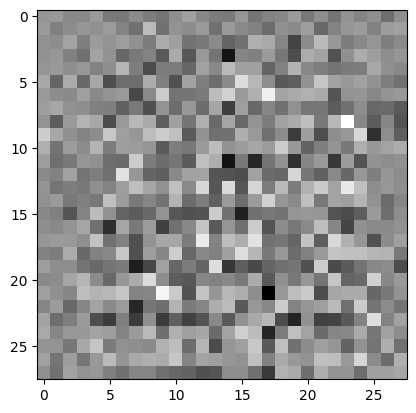

In [4]:
generator = make_generator_model()
generator.summary()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### **2.2. Дискриминаторная модель**

Архитектура дискриминатора принимает на вход изображения размером 28 x 28 и классифицирует их как реальные или сгенерированные. 

**В данной модели:**

1. **Входной слой:**
   - Обрабатывает входные изображения размером 28 x 28 x 1 (одноцветные изображения).
   - Применяет свёртку с ядром 5 x 5, уменьшая размер до 14 x 14 x 64.
   - Используется активация Leaky ReLU для стабильности обучения.
   - Dropout (0.3) снижает риск переобучения.
2. **Сверточный слой:**
   - Уменьшает размер до 7 x 7 x 128 с помощью свёртки 5 x 5 и шага 2 x 2.
   - Используется Leaky ReLU для предотвращения затухания градиентов.
   - Dropout (0.3) для регуляризации.
3. **Выходной слой:**
   - Преобразует данные в одномерный массив (Flatten).
   - Полносвязный слой возвращает скалярное значение, представляющее вероятность того, что изображение является реальным.

**Почему такая структура?**

1. **Оптимизация для малого разрешения**:
   - Простая архитектура с двумя свёрточными слоями подходит для изображений размером 28 x 28, обеспечивая баланс между качеством работы и производительностью.
2. **Регуляризация**:
   - Использование Dropout на каждом свёрточном уровне помогает избежать переобучения.
3. **Leaky ReLU**:
   - Обеспечивает более стабильное обучение за счёт предотвращения "затухающих градиентов".


In [5]:
# Дискриминатор
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [6]:
discriminator = make_discriminator_model()
discriminator.summary()
decision = discriminator(generated_image)
print (decision)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

## **3. Определение наших потерь и оптимизаторы**

In [7]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### **3.1. Потери генератора**

In [8]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### **3.2. Потери дискриминатора**

In [9]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

## **4. Обучение**

### **4.1. Сохранение контрольных точек**

In [10]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### **Цикл обучения**

In [11]:
# История потерь
generator_loss_historyE = []
discriminator_loss_historyE = []

generator_loss_history = []
discriminator_loss_history = []

seed = tf.random.normal([16, noise_dim])

In [12]:
# Обучение
@tf.function
def train_step(images, count):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
        generator_loss_history.append(gen_loss)
        discriminator_loss_history.append(disc_loss)

        if count == 235: # images per batch
            generator_loss_historyE.append(gen_loss)
            discriminator_loss_historyE.append(disc_loss)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [13]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        count = 0
        for image_batch in train_dataset:
            count += 1
            train_step(image_batch, count)
        if (epoch + 1) % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            print(f'Эпоха {epoch + 1} завершена.')
            generate_and_save_images(generator, epoch + 1, seed)
        print(f'Эпоха {epoch + 1} завершена за {time.time() - start:.2f} сек.')

### **Создание и сохранение изображени**

In [14]:
# Визуализация
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    predictions = (predictions + 1) / 2.0  # Перевод в [0, 1]
    plt.figure(figsize=(8, 8))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.suptitle(f'Эпоха {epoch}')
    plt.show()

### **Обучение модели DCGAN**

Эпоха 1 завершена за 20.26 сек.
Эпоха 2 завершена за 17.32 сек.
Эпоха 3 завершена за 16.01 сек.
Эпоха 4 завершена за 15.59 сек.
Эпоха 5 завершена за 15.91 сек.
Эпоха 6 завершена за 16.47 сек.
Эпоха 7 завершена за 16.89 сек.
Эпоха 8 завершена за 16.30 сек.
Эпоха 9 завершена за 15.92 сек.
Эпоха 10 завершена.


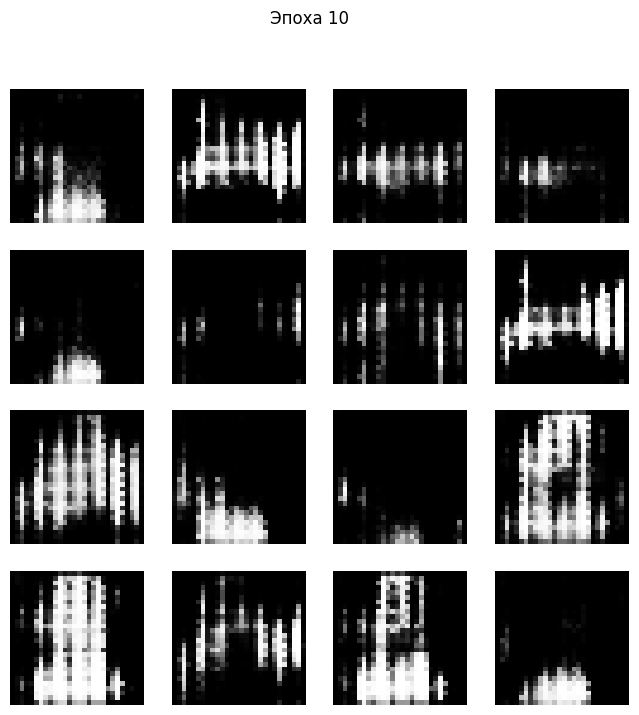

Эпоха 10 завершена за 16.22 сек.
Эпоха 11 завершена за 15.73 сек.
Эпоха 12 завершена за 16.28 сек.
Эпоха 13 завершена за 16.10 сек.
Эпоха 14 завершена за 16.32 сек.
Эпоха 15 завершена за 17.41 сек.
Эпоха 16 завершена за 16.52 сек.
Эпоха 17 завершена за 16.38 сек.
Эпоха 18 завершена за 16.33 сек.
Эпоха 19 завершена за 17.18 сек.
Эпоха 20 завершена.


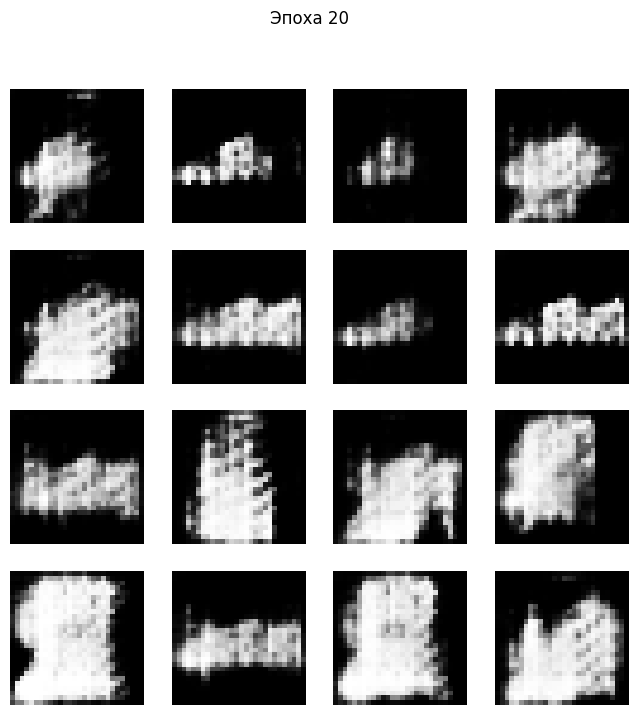

Эпоха 20 завершена за 17.36 сек.
Эпоха 21 завершена за 16.51 сек.
Эпоха 22 завершена за 16.97 сек.
Эпоха 23 завершена за 16.95 сек.
Эпоха 24 завершена за 16.19 сек.
Эпоха 25 завершена за 17.05 сек.
Эпоха 26 завершена за 16.41 сек.
Эпоха 27 завершена за 17.48 сек.
Эпоха 28 завершена за 18.89 сек.
Эпоха 29 завершена за 18.27 сек.
Эпоха 30 завершена.


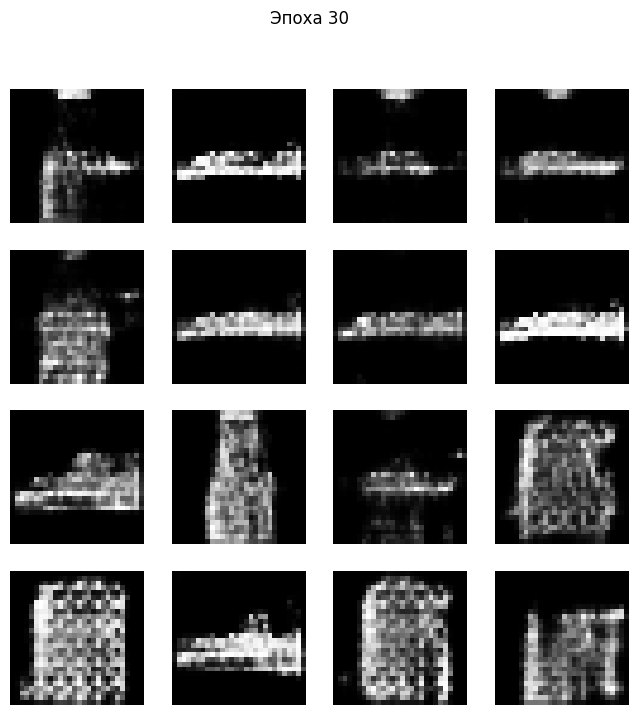

Эпоха 30 завершена за 16.38 сек.
Эпоха 31 завершена за 15.88 сек.
Эпоха 32 завершена за 15.78 сек.
Эпоха 33 завершена за 15.91 сек.
Эпоха 34 завершена за 15.69 сек.
Эпоха 35 завершена за 16.00 сек.
Эпоха 36 завершена за 16.11 сек.
Эпоха 37 завершена за 16.15 сек.
Эпоха 38 завершена за 15.92 сек.
Эпоха 39 завершена за 15.96 сек.
Эпоха 40 завершена.


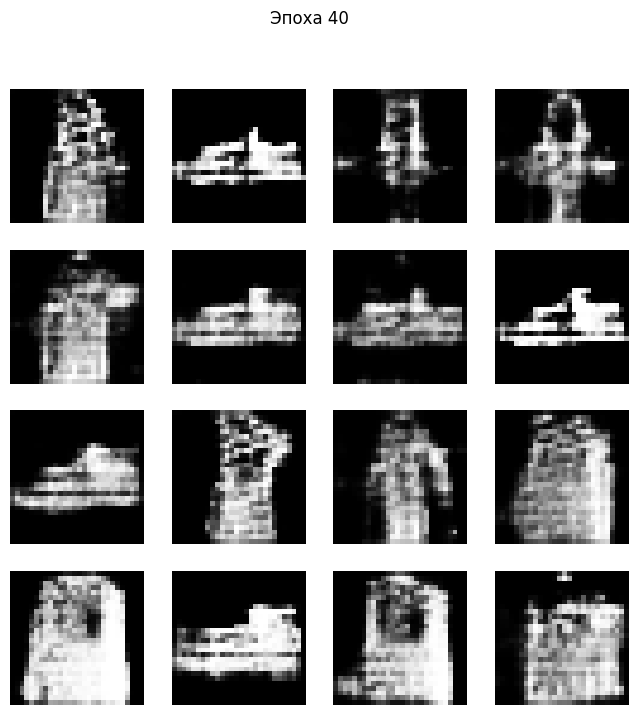

Эпоха 40 завершена за 16.27 сек.
Эпоха 41 завершена за 16.17 сек.
Эпоха 42 завершена за 17.18 сек.
Эпоха 43 завершена за 16.80 сек.
Эпоха 44 завершена за 19.04 сек.
Эпоха 45 завершена за 17.94 сек.
Эпоха 46 завершена за 16.65 сек.
Эпоха 47 завершена за 16.13 сек.
Эпоха 48 завершена за 16.46 сек.
Эпоха 49 завершена за 15.85 сек.
Эпоха 50 завершена.


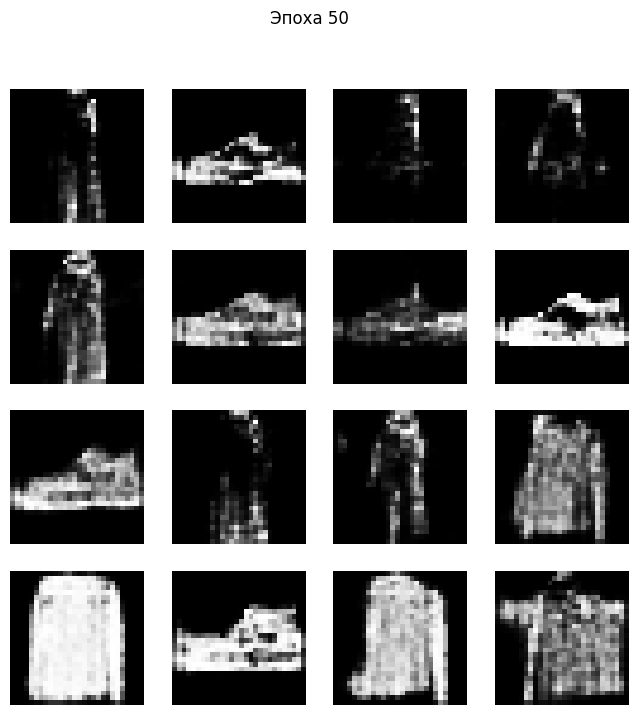

Эпоха 50 завершена за 15.86 сек.


In [15]:
train(train_dataset, EPOCHS)

In [16]:
# Restore Latest Checkpoint
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## **5. Графики потерь**

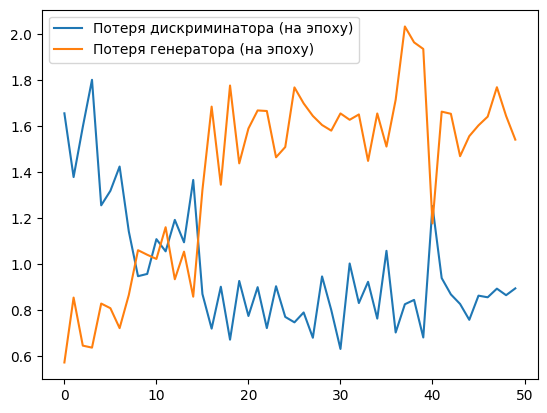

In [17]:
plt.plot(discriminator_loss_historyE, label='Потеря дискриминатора (на эпоху)')
plt.plot(generator_loss_historyE, label='Потеря генератора (на эпоху)')
plt.legend()
plt.show()

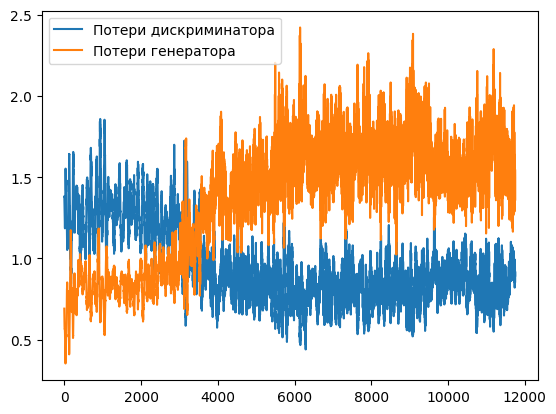

In [18]:
plt.plot(discriminator_loss_history, label='Потери дискриминатора')
plt.plot(generator_loss_history, label='Потери генератора')
plt.legend()
plt.show()

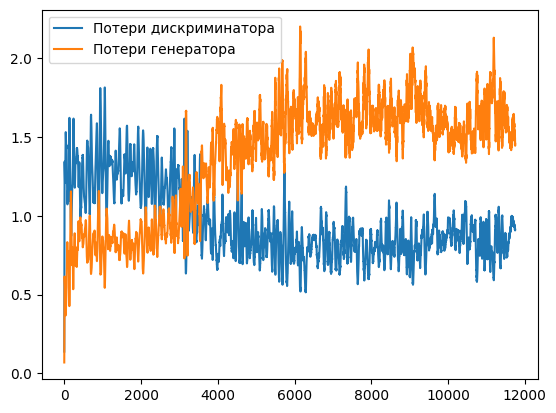

In [19]:
from scipy.signal import lfilter

n = 10
b = [1.0 / n] * n
a = 1
disc_y = lfilter(b,a,discriminator_loss_history)
gen_y = lfilter(b,a,generator_loss_history)
plt.plot(disc_y, label='Потери дискриминатора')
plt.plot(gen_y, label='Потери генератора')
plt.legend()
plt.show()


**Динамика потерь:** 

Потери в дискриминаторе снижались, но потери в генераторе увеличивались. Однако за последнюю четверть всех эпох они почти выровнялись.